In [1]:
import geemap
import ee
import os
import time
from shapely.geometry import shape
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

In [2]:
email = "mt-hvi-zonalstats-service-acco@mt-hvi-zonalstats.iam.gserviceaccount.com"
key_file = "/Users/natebender/Desktop/repo/mt-hvi-zonalstats-6da42ca28c80.json"

# Authenticate and initialize
credentials = ee.ServiceAccountCredentials(email=email, key_file=key_file)
ee.Initialize(credentials)

In [3]:
# Define the area of interest (aoi) as the boundary of Montana.
aoi = ee.FeatureCollection("TIGER/2018/States").filter(ee.Filter.eq("STUSPS", "MT"))
tracts = ee.FeatureCollection("TIGER/2020/TRACT").filter(ee.Filter.eq("STATEFP", "30"))
usa = ee.FeatureCollection("TIGER/2018/States") \
            .filter(ee.Filter.neq('STATEFP', '02'))  # Exclude Alaska (STATEFP '02')

# Load SRTM terrain data and clip to the USA boundaries.
#terrain = ee.Image('USGS/SRTMGL1_003').clip(usa) # full USA terrain view
terrain = ee.Image('USGS/SRTMGL1_003').clip(aoi) # just Montana
terrain_ft = terrain.multiply(3.28084).rename('elevation_ft') # convert meters to ft


## Landsat 8 Surface Temp

In [4]:
# Function to apply scale factors to the Landsat data
def apply_scale_factors(image):
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermal_band = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(optical_bands, None, True).addBands(thermal_band, None, True)

def print_collection_summary(collection):
    images = collection.toList(collection.size()).getInfo()
    for image in images:
        id = image['id']
        date = image['properties']['DATE_ACQUIRED']
        print(f"Image ID: {id}, Date: {date}")

def kelvin_to_fahrenheit(image):
    # Convert the ST_B10 band from Kelvin to Fahrenheit.
    fahrenheit = image.select('ST_B10').subtract(273.15).multiply(9/5).add(32)
    return image.addBands(fahrenheit.rename('ST_Fahrenheit'))

In [5]:
# Get the Landsat 8 image collection.
collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterBounds(aoi) \
    .filterDate('2018-06-01', '2022-08-31') \
    .filter(ee.Filter.calendarRange(6, 8, 'month')) \
    .map(apply_scale_factors) 

In [6]:
start_time = time.time()
num_images = collection.size().getInfo()
print(f"Total number of images: {num_images}")
#print_collection_summary(collection) # print this to see all the image dates
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Total number of images: 959
Execution time: 14.075907230377197 seconds


In [7]:
start_time = time.time()
filtered_collection = collection.filter(ee.Filter.lte('CLOUD_COVER', 10)) #lte stands for less than or equal to
num_images = filtered_collection.size().getInfo()
print(f"Total number of images: {num_images}")
#print_collection_summary(filtered_collection) # print this to see all the image dates

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Total number of images: 399
Execution time: 3.674330949783325 seconds


In [8]:
bad_composite = collection.mean().clip(aoi)
good_composite = filtered_collection.mean().clip(aoi)

# Convert the composites to Fahrenheit.
bad_composite_f = kelvin_to_fahrenheit(bad_composite)
good_composite_f = kelvin_to_fahrenheit(good_composite)


In [39]:
# check impact of filtering by cloud cover
m = geemap.Map()
m.set_center(-110, 47, 6)

vis_params = {'min': 30, 'max': 120,     
              'palette': ['000004', '1b0c41', '4a0c6b', '781c6d', 'a52c60', 
                          'cf4446', 'ed6925', 'fb9b06', 'f7d13d', 'fcffa4']
             }

# Define the legend dictionary
legend_dict = {
    '30-40°F': '#000004',
    '40-50°F': '#1b0c41',
    '50-60°F': '#4a0c6b',
    '60-70°F': '#781c6d',
    '70-80°F': '#a52c60',
    '80-90°F': '#cf4446',
    '90-100°F': '#ed6925',
    '100-110°F': '#fb9b06',
    '110-120°F': '#f7d13d',
    '120+°F': '#fcffa4'
}

# Add the Fahrenheit layer for bad_composite.
m.add_layer(
    bad_composite_f,
    {'bands': ['ST_Fahrenheit'], **vis_params},
    'Bad composite (F)',
)

# Add the Fahrenheit layer for good_composite.
m.add_layer(
    good_composite_f,
    {'bands': ['ST_Fahrenheit'], **vis_params},
    'Avg Summer Temp, 2018-2022',
)

# Add the Montana boundary to the map with styling.
m.add_layer(
    aoi.style(color='black', fillColor='00000000'),  # '00000000' represents no fill color
    {},
    'Montana',
)

# add Census Tracts
m.add_layer(
    tracts.style(color='black', fillColor='00000000'),  # '00000000' represents no fill color
    {},
    'Tracts',
)

m.setControlVisibility(layerControl=True, fullscreenControl=True, latLngPopup=True)
m.add_legend(title="Temperature (°F)", legend_dict=legend_dict)

m

Map(center=[47, -110], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

In [10]:
start_time = time.time()
mean_dict = good_composite_f.select('ST_Fahrenheit').reduceRegions(
    collection=tracts,
    reducer=ee.Reducer.mean(),
    scale=30
)
# Print the result (limited to first few tracts for brevity).
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 0.00025916099548339844 seconds


In [11]:
results = mean_dict.getInfo()['features']
data = []
for feature in results:
    props = feature['properties']
    data.append({
        'GEOID': props['GEOID'],
        'NAME': props['NAME'],
        'mean_temp_f': props['mean']
    })

In [12]:
# Convert the list of dictionaries to a pandas DataFrame.
mean_temp_df = pd.DataFrame(data)
mean_temp_df = mean_temp_df.rename(columns={'GEOID': 'geo_id'})
mean_temp_df.head()

,geo_id,NAME,mean_temp_f
0,30053000100,1,84.776842
1,30089000100,1,86.642966
2,30077000100,1,88.678175
3,30081000100,1,86.079701
4,30079000100,1,109.811034


In [13]:
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)
csv_path = os.path.join(output_dir, 'tract_avg_summertemp_2018-22.csv')
# mean_temp_df.to_csv(csv_path, index=False)

## Tree Canopy


In [14]:
dataset = ee.ImageCollection('USGS/NLCD_RELEASES/2021_REL/TCC/v2021-4')\
    .filterBounds(aoi) \
    .filter(ee.Filter.calendarRange(2021, 2021, 'year'))

nlcd_tree_canopy = dataset.select('NLCD_Percent_Tree_Canopy_Cover').first().clip(aoi.geometry())

In [15]:
start_time = time.time()
zonal_stats = nlcd_tree_canopy.reduceRegions(
    collection=tracts,
    reducer=ee.Reducer.mean(),
    scale=30
).getInfo()

features = zonal_stats['features']
gdf_features = []
for feature in features:
    geom = shape(feature['geometry'])
    properties = feature['properties']
    properties['geometry'] = geom
    gdf_features.append(properties)

canopy_gdf = gpd.GeoDataFrame(gdf_features, crs='epsg:4326')
canopy_gdf = canopy_gdf[['GEOID', 'mean', 'geometry']]
canopy_gdf = canopy_gdf.rename(columns={'GEOID': 'geo_id', 'mean': 'mean_perc_canopy'})
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 11.468276262283325 seconds


In [16]:
canopy_gdf.head()

,geo_id,mean_perc_canopy,geometry
0,30053000100,51.262244,"POLYGON ((-115.56283 48.38159, -115.56284 48.3..."
1,30089000100,42.047404,"POLYGON ((-115.29581 47.75034, -115.29574 47.7..."
2,30077000100,28.269735,"POLYGON ((-112.31057 46.42117, -112.31179 46.4..."
3,30081000100,23.058006,"POLYGON ((-114.34420 46.58997, -114.34357 46.5..."
4,30079000100,0.160079,"POLYGON ((-106.08680 47.16731, -106.08679 47.1..."


## Imperviousness

In [17]:
dataset = ee.ImageCollection('USGS/NLCD_RELEASES/2021_REL/NLCD')
impervious = dataset.filter(ee.Filter.calendarRange(2021, 2021, 'year')).first().select('impervious').clip(aoi.geometry())

In [18]:
start_time = time.time()
zonal_stats = impervious.reduceRegions(
    collection=tracts,
    reducer=ee.Reducer.mean(),
    scale=30
).getInfo()
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 12.295244932174683 seconds


In [19]:
features = zonal_stats['features']
gdf_features = []
for feature in features:
    geom = shape(feature['geometry'])
    properties = feature['properties']
    properties['geometry'] = geom
    gdf_features.append(properties)

impervious_gdf = gpd.GeoDataFrame(gdf_features, crs='epsg:4326')

# Keep only 'GEOID' and 'mean' columns, and rename them
impervious_gdf = impervious_gdf[['GEOID', 'mean', 'geometry']]
impervious_gdf = impervious_gdf.rename(columns={'GEOID': 'geo_id', 'mean': 'mean_perc_impervious'})

In [20]:
impervious_gdf.sort_values(by="mean_perc_impervious")

,geo_id,mean_perc_impervious,geometry
246,30035980000,0.027687,"POLYGON ((-114.06818 48.99886, -114.06809 48.9..."
247,30067980600,0.069624,"POLYGON ((-111.04506 45.07390, -111.04506 45.0..."
141,30029000102,0.075204,"POLYGON ((-113.92011 48.14073, -113.92007 48.1..."
137,30029000101,0.091266,"POLYGON ((-114.88873 48.59888, -114.88873 48.5..."
15,30049000100,0.095741,"POLYGON ((-112.37308 47.08671, -112.37308 47.0..."
...,...,...,...
96,30111001000,66.046008,"POLYGON ((-108.54234 45.76260, -108.54220 45.7..."
251,30063001002,66.482265,"POLYGON ((-114.02814 46.85953, -114.02817 46.8..."
56,30111000300,67.683392,"POLYGON ((-108.52795 45.76964, -108.52689 45.7..."
143,30093000102,71.182616,"POLYGON ((-112.54212 46.01654, -112.54212 46.0..."


### Merge canopy and imperviousness data

In [21]:
df_final = canopy_gdf.merge(impervious_gdf, on='geo_id', suffixes=('_canopy', '_impervious'))
# Keep only 'GEOID' and 'mean' columns, and rename them
df_final = df_final[['geo_id', 'mean_perc_impervious', 'mean_perc_canopy', 'geometry_canopy']]
df_final = df_final.rename(columns={'geometry_canopy': 'geometry'})

# switch to projected crs and calculate area
df_final = gpd.GeoDataFrame(df_final, geometry='geometry', crs='epsg:5070')
df_final['area_sq_miles'] = df_final['geometry'].area / 2.59e+6

# convert back to 4326 crs
df_final = df_final.to_crs(epsg=4326)


In [22]:
numerator = -1 * (df_final['mean_perc_canopy'] * df_final['area_sq_miles'] - df_final['mean_perc_impervious'] * df_final['area_sq_miles'])
denominator = (df_final['mean_perc_canopy'] * df_final['area_sq_miles'] + df_final['mean_perc_impervious'] * df_final['area_sq_miles'])

# Calculate the impervious_canopy_index
df_final['impervious_canopy_index'] = numerator / denominator

In [23]:
df_final.sort_values(by="impervious_canopy_index")

,geo_id,mean_perc_impervious,mean_perc_canopy,geometry,area_sq_miles,impervious_canopy_index
246,30035980000,0.027687,28.872932,"POLYGON ((-96.00109 23.00045, -96.00109 23.000...",7.143839e-08,-0.998084
141,30029000102,0.075204,44.224298,"POLYGON ((-96.00109 23.00044, -96.00109 23.000...",2.133993e-07,-0.996605
137,30029000101,0.091266,46.099270,"POLYGON ((-96.00110 23.00045, -96.00110 23.000...",2.251868e-07,-0.996048
291,30063001801,0.098801,43.155214,"POLYGON ((-96.00109 23.00043, -96.00109 23.000...",8.346152e-08,-0.995432
8,30047000100,0.127286,54.997564,"POLYGON ((-96.00109 23.00044, -96.00109 23.000...",4.544196e-08,-0.995382
...,...,...,...,...,...,...
53,30093000300,50.826182,0.243111,"POLYGON ((-96.00108 23.00042, -96.00108 23.000...",1.015539e-10,0.990479
65,30093000400,59.335064,0.267569,"POLYGON ((-96.00108 23.00042, -96.00108 23.000...",1.151221e-10,0.991022
260,30013001201,42.125427,0.108418,"POLYGON ((-96.00106 23.00044, -96.00106 23.000...",5.813592e-11,0.994866
263,30013001202,17.562539,0.022314,"POLYGON ((-96.00106 23.00044, -96.00106 23.000...",7.697453e-10,0.997462


### merge temperature data

In [24]:
mean_temp_df.head()

,geo_id,NAME,mean_temp_f
0,30053000100,1,84.776842
1,30089000100,1,86.642966
2,30077000100,1,88.678175
3,30081000100,1,86.079701
4,30079000100,1,109.811034


In [25]:
df_final = df_final.merge(mean_temp_df[['geo_id', 'mean_temp_f']], on='geo_id')
df_final = df_final[['geo_id', 'mean_perc_impervious', 'mean_perc_canopy', 'impervious_canopy_index', 'mean_temp_f', 'area_sq_miles']]

In [26]:
df_final.head()

,geo_id,mean_perc_impervious,mean_perc_canopy,impervious_canopy_index,mean_temp_f,area_sq_miles
0,30053000100,0.375692,51.262244,-0.985449,84.776842,1.194955e-07
1,30089000100,0.271138,42.047404,-0.987186,86.642966,1.078215e-07
2,30077000100,0.126999,28.269735,-0.991055,88.678175,2.322864e-07
3,30081000100,0.696844,23.058006,-0.941330,86.079701,1.210486e-08
4,30079000100,0.200198,0.160079,0.111357,109.811034,2.055484e-07


In [27]:
csv_path = os.path.join(output_dir, 'df_raster_analysis_final.csv')
# df_final.to_csv(csv_path, index=False)

## Explore the data!

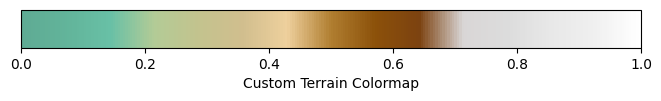

In [28]:
colors = [
    '#5fab94', '#62b49a',   # reduced greenish-blues
    '#68c0a6',  # light green
    '#b3cb96', '#c3c38e', '#d1be8e', '#eed09d',  # expanded tans
    '#b07e30', '#8c510a', '#7c4210',  # expanded browns
    '#d9d6d6', '#dcdcdc', '#e8e8e8', '#f0f0f0', '#FFFFFF'  # greys and whites
]

# Create a segmented colormap from the list of colors
custom_cmap = LinearSegmentedColormap.from_list("custom_terrain", colors, N=256)

# Visualize the custom colormap
fig, ax = plt.subplots(figsize=(8, 1))
fig.subplots_adjust(bottom=0.5)

# Display the colormap
cb = fig.colorbar(plt.cm.ScalarMappable(cmap=custom_cmap), cax=ax, orientation='horizontal')
cb.set_label('Custom Terrain Colormap')
plt.show()

In [29]:
# Generate the custom palette
n_colors = 500
custom_palette = [mcolors.rgb2hex(custom_cmap(i / n_colors)) for i in range(n_colors)]

def get_palette_index(elevation, max_elevation, n_colors):
    index = int(elevation / max_elevation * (n_colors - 1))
    return min(index, n_colors - 1)

In [30]:
# Define the legend dictionary for tree canopy cover.
tree_canopy_legend_dict = {
    '0-10%': '#ffffff',
    '10-20%': '#d9f0d3',
    '20-30%': '#addd8e',
    '30-40%': '#78c679',
    '40-50%': '#41ab5d',
    '50-60%': '#238443',
    '60-70%': '#006837',
    '70-80%': '#004529',
    '80-90%': '#003300',
    '90-100%': '#002200'
}

tree_canopy_vis_params = {
    'min': 0,
    'max': 100,
    'palette': ['ffffff', '006400']
}

terrain_vis_params = {
    'min': 0,
    'max': 15000,
    'palette': custom_palette
}

# Define a simplified legend dictionary for display purposes.
terrain_legend_dict = {
    '0-1000 ft': custom_palette[int(1000 / 15000 * (n_colors - 1))],
    '1000-2000 ft': custom_palette[int(2000 / 15000 * (n_colors - 1))],
    '2000-3000 ft': custom_palette[int(3000 / 15000 * (n_colors - 1))],
    '3000-4000 ft': custom_palette[int(4000 / 15000 * (n_colors - 1))],
    '4000-5000 ft': custom_palette[int(5000 / 15000 * (n_colors - 1))],
    '5000-6000 ft': custom_palette[int(6000 / 15000 * (n_colors - 1))],
    '6000-7000 ft': custom_palette[int(7000 / 15000 * (n_colors - 1))],
    '7000-8000 ft': custom_palette[int(8000 / 15000 * (n_colors - 1))],
    '8000-9000 ft': custom_palette[int(9000 / 15000 * (n_colors - 1))],
    '9000-10000 ft': custom_palette[int(10000 / 15000 * (n_colors - 1))],
    '10000-11000 ft': custom_palette[int(11000 / 15000 * (n_colors - 1))],
    '11000-12000 ft': custom_palette[int(12000 / 15000 * (n_colors - 1))],
    '12000-13000 ft': custom_palette[int(13000 / 15000 * (n_colors - 1))],
    '13000-14000 ft': custom_palette[int(14000 / 15000 * (n_colors - 1))],
    '14000-15000 ft': custom_palette[-1]
}



temp_vis_params = {'min': 30, 'max': 120,     
              'palette': ['000004', '1b0c41', '4a0c6b', '781c6d', 'a52c60', 
                          'cf4446', 'ed6925', 'fb9b06', 'f7d13d', 'fcffa4']
             }

# Define the legend dictionary
temp_legend_dict = {
    '30-40°F': '#000004',
    '40-50°F': '#1b0c41',
    '50-60°F': '#4a0c6b',
    '60-70°F': '#781c6d',
    '70-80°F': '#a52c60',
    '80-90°F': '#cf4446',
    '90-100°F': '#ed6925',
    '100-110°F': '#fb9b06',
    '110-120°F': '#f7d13d',
    '120+°F': '#fcffa4'
}

impervious_vis_params = {
    'min': 0,
    'max': 100,
    'palette': ['#ffffff', '#e0e0e0', '#c0c0c0', '#808080', '#404040', '#000000']  # Very light greys to black
}

# Define the legend dictionary with breaks every 20%.
impervious_legend_dict = {
    '0-20%': '#ffffff',
    '21-40%': '#e0e0e0',
    '41-60%': '#c0c0c0',
    '61-80%': '#808080',
    '81-100%': '#000000'
}

In [31]:
m = geemap.Map()
m.set_center(-110, 47, 6)

# Add the Fahrenheit layer for good_composite.
m.add_layer(
    good_composite_f,
    {'bands': ['ST_Fahrenheit'], **temp_vis_params},
    'Avg Summer Temp, 2018-2022',
)

m.add_layer(
    nlcd_tree_canopy,
    tree_canopy_vis_params,
    'Tree Canopy Cover'
)

m.add_layer(
    impervious,
    impervious_vis_params,
    'Impervious Surface'
)

m.add_layer(
    terrain_ft,
    terrain_vis_params,
    'Terrain (feet)'
)

# Add the Montana boundary to the map with styling.
m.add_layer(
    aoi.style(color='black', fillColor='00000000'),  # '00000000' represents no fill color
    {},
    'Montana',
)

# add Census Tracts
m.add_layer(
    tracts.style(color='black', fillColor='00000000'),  # '00000000' represents no fill color
    {},
    'Tracts',
)

m.setControlVisibility(layerControl=True, fullscreenControl=True, latLngPopup=True)
m.add_legend(title="Tree Canopy Cover (%)", legend_dict=tree_canopy_legend_dict)
m.add_legend(title="Elevation (feet)", legend_dict=terrain_legend_dict)
m.add_legend(title="Temperature (°F)", legend_dict=temp_legend_dict)
m.add_legend(title="Impervious Surface (%)", legend_dict=impervious_legend_dict)

m

Map(center=[47, -110], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

In [40]:
# Define the file path for the export
impervious_path = os.path.join(output_dir, 'impervious_export.tif')
canopy_path = os.path.join(output_dir, 'canopy_export.tif')
temp_path = os.path.join(output_dir, 'temp_export.tif')

geemap.ee_export_image(impervious, filename=impervious_path, scale=200)

Generating URL ...
Please wait ...
Data downloaded to /Users/natebender/Desktop/repo/mslacounty_hvi/outputs/impervious_export.tif


In [41]:
geemap.ee_export_image(nlcd_tree_canopy, filename=canopy_path, scale=200)

Generating URL ...
Please wait ...
Data downloaded to /Users/natebender/Desktop/repo/mslacounty_hvi/outputs/canopy_export.tif


In [48]:
print(type(nlcd_tree_canopy))
print(type(impervious))
print(type(good_composite_f))

<class 'ee.image.Image'>
<class 'ee.image.Image'>
<class 'ee.image.Image'>


In [52]:
print(impervious.getInfo())


{'type': 'Image', 'bands': [{'id': 'impervious', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [30080, 19073], 'origin': [33169, 8852], 'crs': 'PROJCS["Albers_Conical_Equal_Area", \n  GEOGCS["WGS 84", \n    DATUM["WGS_1984", \n      SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG","7030"]], \n      AUTHORITY["EPSG","6326"]], \n    PRIMEM["Greenwich", 0.0], \n    UNIT["degree", 0.017453292519943295], \n    AXIS["Longitude", EAST], \n    AXIS["Latitude", NORTH], \n    AUTHORITY["EPSG","4326"]], \n  PROJECTION["Albers_Conic_Equal_Area"], \n  PARAMETER["central_meridian", -96.0], \n  PARAMETER["latitude_of_origin", 23.0], \n  PARAMETER["standard_parallel_1", 29.5], \n  PARAMETER["false_easting", 0.0], \n  PARAMETER["false_northing", 0.0], \n  PARAMETER["standard_parallel_2", 45.5], \n  UNIT["m", 1.0], \n  AXIS["Easting", EAST], \n  AXIS["Northing", NORTH]]', 'crs_transform': [30, 0, -2493045, 0, -30, 3310005]}], 'version': 16944482

In [ ]:
print(nlcd_tree_canopy.getInfo())


In [54]:
bounds = good_composite_f.geometry().bounds()
print(bounds.getInfo())

{'type': 'Polygon', 'coordinates': [[[-180, -90], [180, -90], [180, 90], [-180, 90], [-180, -90]]]}


In [53]:
print(good_composite_f.getInfo())

{'type': 'Image', 'bands': [{'id': 'SR_B1', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': -0.2, 'max': 1.6022125}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'SR_B2', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': -0.2, 'max': 1.6022125}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'SR_B3', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': -0.2, 'max': 1.6022125}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'SR_B4', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': -0.2, 'max': 1.6022125}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'SR_B5', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': -0.2, 'max': 1.6022125}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'SR_B6', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': -0.2, 'max': 1.6022125}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0,

In [50]:
geemap.ee_export_image(good_composite_f, filename=temp_path, scale=200)

Generating URL ...
An error occurred while downloading.
Image.clipToBoundsAndScale: The geometry for image clipping must be bounded.
